Plots of the observations, the mask and some histograms based on the observations.      
The interpolation will be performed in notebook [interp_Calanus](interp_Calanus.ipynb).

In [1]:
using CSV
using Dates
using DelimitedFiles 
using NCDatasets
using PyPlot
using DIVAnd
using Statistics
const plt=PyPlot
using PyCall
using PyPlot
colors = PyCall.pyimport("matplotlib.colors")
ccrs = PyCall.pyimport("cartopy.crs")
cfeature = PyCall.pyimport("cartopy.feature")
mticker = PyCall.pyimport("matplotlib.ticker")
coast = cfeature.GSHHSFeature(scale="full");
cartopyticker = PyCall.pyimport("cartopy.mpl.ticker")
lon_formatter = cartopyticker.LongitudeFormatter()
lat_formatter = cartopyticker.LatitudeFormatter()
cmocean = PyCall.pyimport("cmocean")
plt.rc("font", family="Times New Roman", size=16)
include("../src/InterpCalanus.jl")
makeplot = true
usecartopy = false

false

## 1. Setting
### 1.1 Colors, domain, projection 

In [2]:
makeplot = true
mycolor = "#6667AB"
mycolor2 = "#456A30" # Green treetop
dom = [-20.5, 11.75, 41.25, 67.]
mainproj = ccrs.Mercator(central_longitude=0.5*(dom[1] + dom[2]),
                         min_latitude=dom[3], max_latitude=dom[4])
datacrs = ccrs.PlateCarree()

PyObject <Derived Projected CRS: +proj=eqc +ellps=WGS84 +a=6378137.0 +lon_0=0.0 +to ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (unknown)
- N[north]: Northing (unknown)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Equidistant Cylindrical
Datum: unknown
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### 1.2 Files and directories

In [25]:
datadir = "../data/"
figdir = "../figures/L05"
resdir = "../results/L05"
resdirm = "../results/monthly/L05"
isdir(datadir) ? @debug("already there") : mkpath(datadir)
isdir(resdir) ? @debug("already there") : mkpath(resdir)
isdir(resdirm) ? @debug("already there") : mkpath(resdirm)
isdir(figdir) ? @debug("already there") : mkpath(figdir)
datafile = joinpath(datadir, "MBA_CPRdata_Emodnet_21Jan22.csv")
isfile(datafile) ? @debug("already downloaded") : download("https://dox.ulg.ac.be/index.php/s/hjWKf1F3C1Pzz1r/download", datafile)
bathfile = joinpath(datadir, "gebco_30sec_16.nc")
isfile(bathfile) ? @debug("already downloaded") : download("https://dox.ulg.ac.be/index.php/s/U0pqyXhcQrXjEUX/download", bathfile)
isfile(datafile), isfile(bathfile)

(true, true)

### 1.3 Grid configuration

In [26]:
Δlon = 0.5
Δlat = 0.5
longrid = dom[1]:Δlon:dom[2]
latgrid = dom[3]:Δlat:dom[4]

41.25:0.5:66.75

## 2. Analysis preparation
### 2.1 Metrics

In [27]:
_, (pm, pn), (xi, yi) = DIVAnd_rectdom(longrid, latgrid);
@info(size(xi));

┌ Info: (65, 52)
└ @ Main In[27]:2


### Prepare mask

In [28]:
bx, by, b = DIVAnd.load_bath(bathfile, true, longrid, latgrid)
@show size(b), size(bx), size(by)

(size(b), size(bx), size(by)) = ((65, 52), (65,), (52,))


((65, 52), (65,), (52,))

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


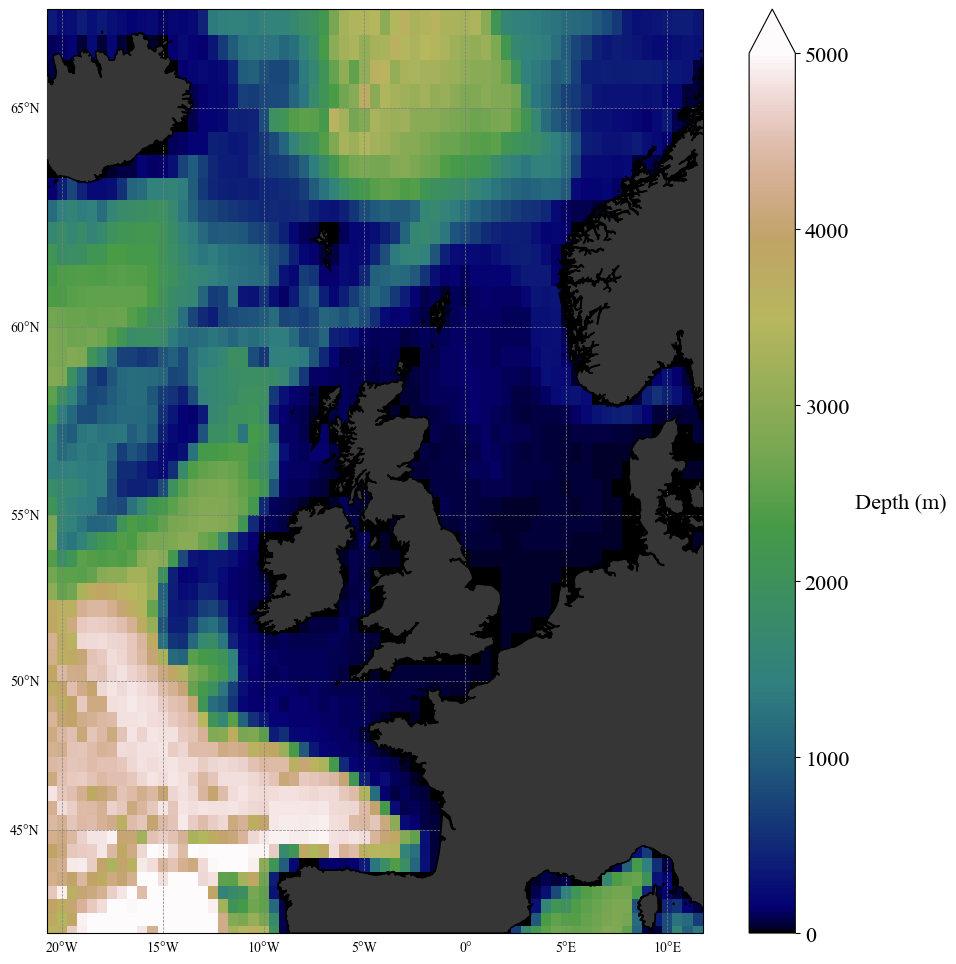

In [7]:
if makeplot
    fig = plt.figure(figsize=(12, 12))
    ax = plt.subplot(111, projection=mainproj)
    pcm = ax.pcolormesh(bx, by, b', vmin=0., vmax=5000., cmap=PyPlot.cm.gist_earth, transform=datacrs);
    ax.add_feature(coast, facecolor="#363636", edgecolor="k", zorder=5)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                          linewidth=.5, color="gray", alpha=1, linestyle="--")
    gl.top_labels = false
    gl.right_labels = false
    gl.xformatter = lon_formatter
    gl.yformatter = lat_formatter
    gl.xlabel_style = Dict("size" => 10)
    gl.ylabel_style = Dict("size" => 10)

    cb = plt.colorbar(pcm, orientation="vertical", extend="max")
    cb.set_label("Depth (m)", rotation=0, ha="left")
    plt.savefig(joinpath(figdir, "domain_bathy_050"), dpi=300, bbox_inches="tight")
    plt.show()
    # plt.close()
end

In [23]:
_, _, mask = DIVAnd.load_mask(bathfile, true, longrid, latgrid, 5.0);
# Remove Mediterranean Sea

# - Resolution = 0.1°
# mask[220:end,1:60] .= 0;

# - Resolution = 0.5°
maskindex = findall((xi .>= 0.) .& (yi .<= 47.))
mask[maskindex] .= 0.;

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


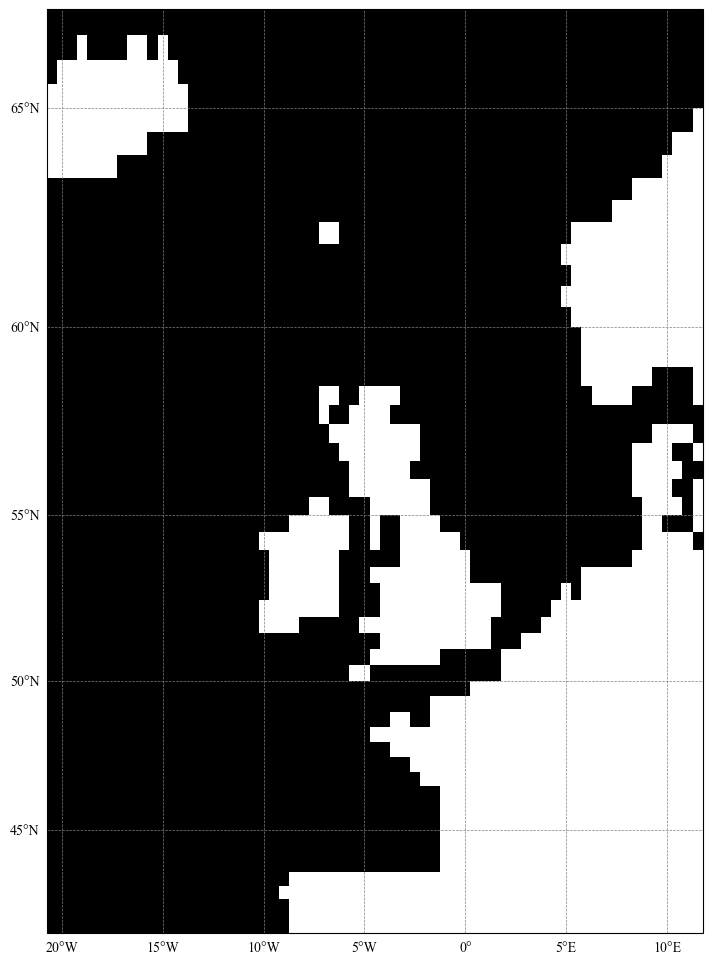

In [24]:
if makeplot

    fig = plt.figure(figsize=(12, 12))
    ax = plt.subplot(111, projection=mainproj)
    pcm = ax.pcolormesh(bx, by, mask', cmap=PyPlot.cm.binary, transform=datacrs)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
        linewidth=.5, color="gray", alpha=1, linestyle="--")
    gl.top_labels = false
    gl.right_labels = false
    gl.xformatter = lon_formatter
    gl.yformatter = lat_formatter
    gl.xlabel_style = Dict("size" => 10)
    gl.ylabel_style = Dict("size" => 10)

    plt.savefig(joinpath(figdir, "domain_mask_05_5meters"), dpi=300, bbox_inches="tight")
    plt.show()
end

## Data reading
### Read the CSV files and separate by columns

In [10]:
@time lon, lat, dates, calanus_finmarchicus, calanus_helgolandicus = InterpCanalus.read_data_calanus(datafile);

  0.613393 seconds (5.74 M allocations: 196.397 MiB, 6.96% gc time, 56.22% compilation time)


┌ Info: (-20.447, 11.703)
└ @ Main.InterpCanalus /home/ctroupin/Projects/EMODnet-Biology/EMODnet-Bio-Interp-Calanus/src/InterpCalanus.jl:29
┌ Info: (41.2567, 66.808)
└ @ Main.InterpCanalus /home/ctroupin/Projects/EMODnet-Biology/EMODnet-Bio-Interp-Calanus/src/InterpCalanus.jl:30


In [11]:
yearcount, monthcount = InterpCanalus.count_years_months(dates)

([2364.0, 2321.0, 2382.0, 2564.0, 2465.0, 2556.0, 2777.0, 2422.0, 2679.0, 2489.0  …  2515.0, 2764.0, 2747.0, 2517.0, 2827.0, 2798.0, 2486.0, 2695.0, 2041.0, 2206.0], [10608.0, 11745.0, 12808.0, 12546.0, 12452.0, 12122.0, 12662.0, 12530.0, 12513.0, 12623.0, 12232.0, 11317.0])

### Year histogram

In [12]:
yearlist = collect(minimum(Dates.year.(dates)):maximum(Dates.year.(dates)));

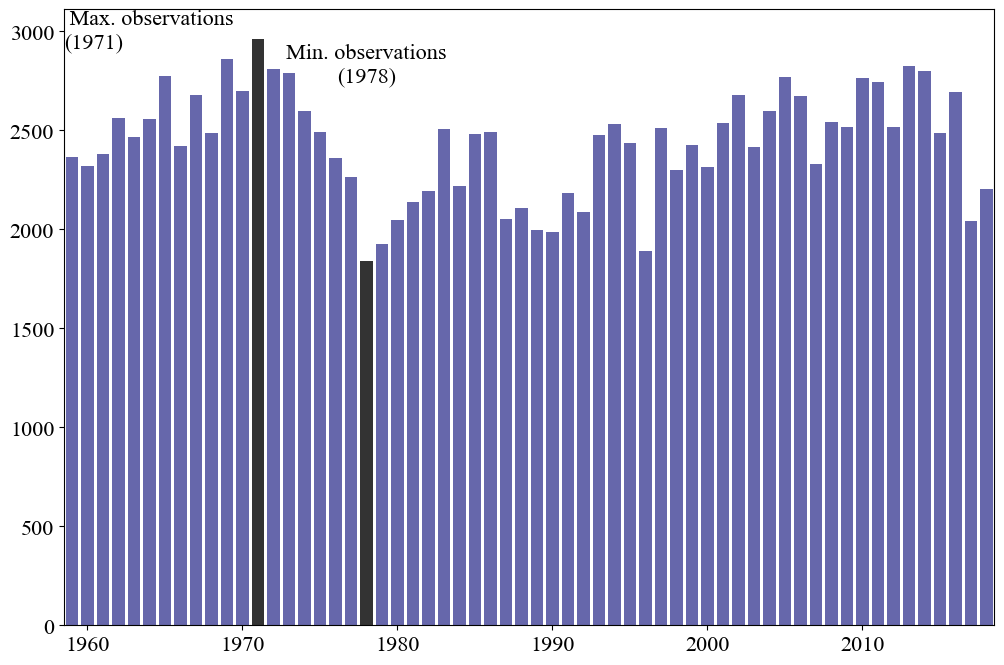

In [13]:
if makeplot

    
    fig = plt.figure(figsize=(12, 8))
    ax = plt.subplot(111)
    ax.set_xlim(yearlist[1] - 0.5, yearlist[end] + 0.5)
    
    
    ax.annotate("Min. observations\n($(yearlist[argmin(yearcount)]))", 
        xy=(yearlist[argmin(yearcount)], minimum(yearcount)), 
            xycoords="data",
            xytext=(yearlist[argmin(yearcount)], minimum(yearcount)+ 1100.), textcoords="data",
            horizontalalignment="center", verticalalignment="top",
            )
    plt.bar(yearlist[argmin(yearcount)], minimum(yearcount), color=".2", zorder=2)
    
    ax.text(0, 1, " Max. observations\n($(yearlist[argmax(yearcount)]))", 
        transform=ax.transAxes, 
        horizontalalignment="left", verticalalignment="top")
     

    plt.bar(yearlist[argmax(yearcount)], maximum(yearcount), color=".2", zorder=2)
    
    plt.bar(yearlist, yearcount, color=mycolor)
    plt.savefig(joinpath(figdir, "time_histogram_year"), dpi=300, bbox_inches="tight")
    #plt.show()
    #plt.close()
end

### Month histogram

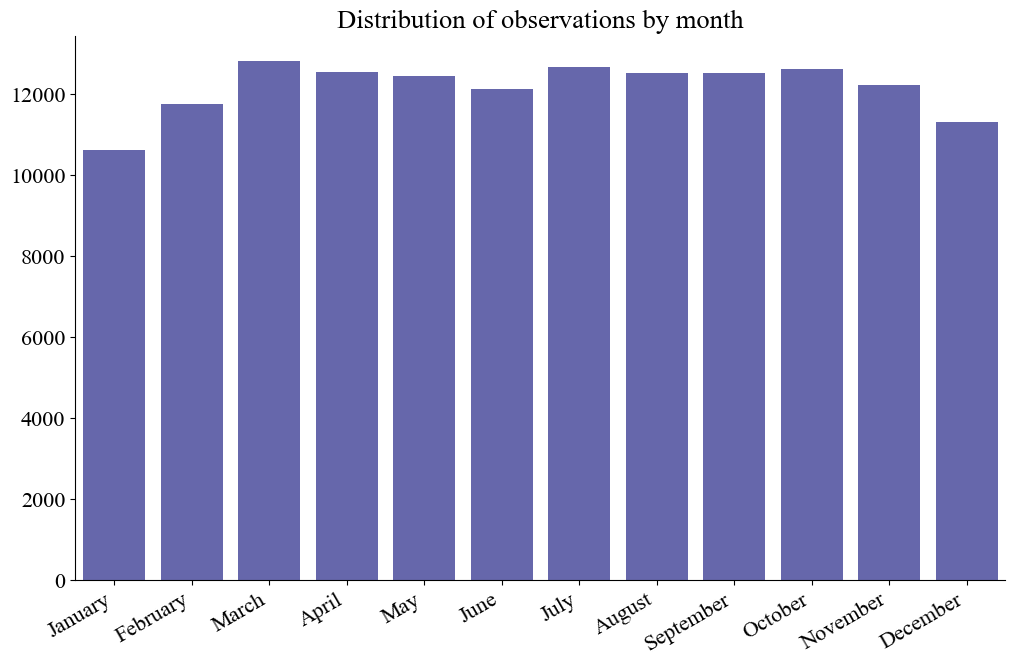

In [14]:
if makeplot
    fig = plt.figure(figsize=(12, 8))
    ax = plt.subplot(111)
    plt.bar(1:12, monthcount, color=mycolor)
    ax.set_title("Distribution of observations by month")
    ax.set_xlim(0.5, 12.5)
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
    ax.set_xticks(collect(1:12), Dates.monthname.(1:12))
    fig.autofmt_xdate()
    plt.savefig(joinpath(figdir, "time_histogram_month"), dpi=300, bbox_inches="tight")
    plt.show()
    # plt.close()
end

### Polar

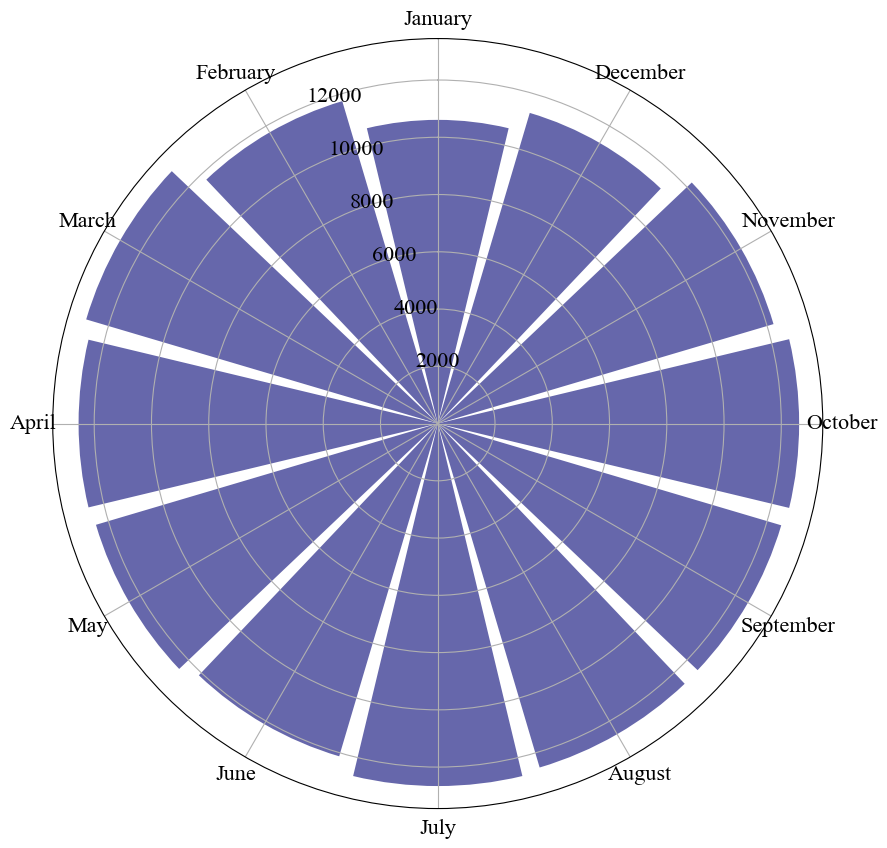

In [15]:
if makeplot

    N = 12
    theta = LinRange(0, 2 * π - π/6, N)
    width = (1.8 * π) / N
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=true)
    ax.set_thetagrids(collect(0:30:330), Dates.monthname.(1:12), color="k")
    ax.set_theta_zero_location("N")
    bars = ax.bar(theta, monthcount, width=width, color=mycolor)
    plt.savefig(joinpath(figdir, "time_histogram_month_polar"), dpi=300, bbox_inches="tight")
    # plt.close()
end

## Spatial distribution

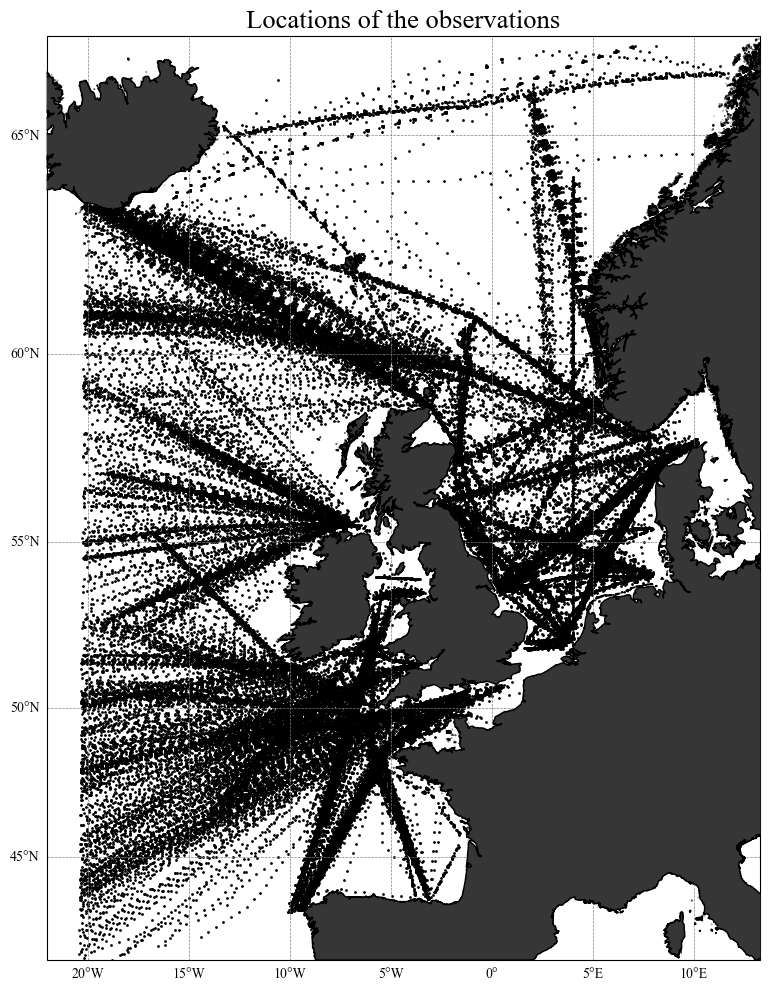

In [16]:
if makeplot

    fig = plt.figure(figsize=(12, 12))
    ax = plt.subplot(111, projection=mainproj)
    ax.plot(lon, lat, "ko", markersize=1, transform=datacrs)
    ax.add_feature(coast, facecolor="#363636", edgecolor="k", zorder=5)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                          linewidth=.5, color="gray", alpha=1, linestyle="--")
    gl.top_labels = false
    gl.right_labels = false
    gl.xformatter = lon_formatter
    gl.yformatter = lat_formatter
    gl.xlabel_style = Dict("size" => 10)
    gl.ylabel_style = Dict("size" => 10)
    ax.set_title("Locations of the observations")
    plt.savefig(joinpath(figdir, "location_obs"), dpi=300, bbox_inches="tight")
    plt.show()
    # plt.close()
end

### Hexbin maps

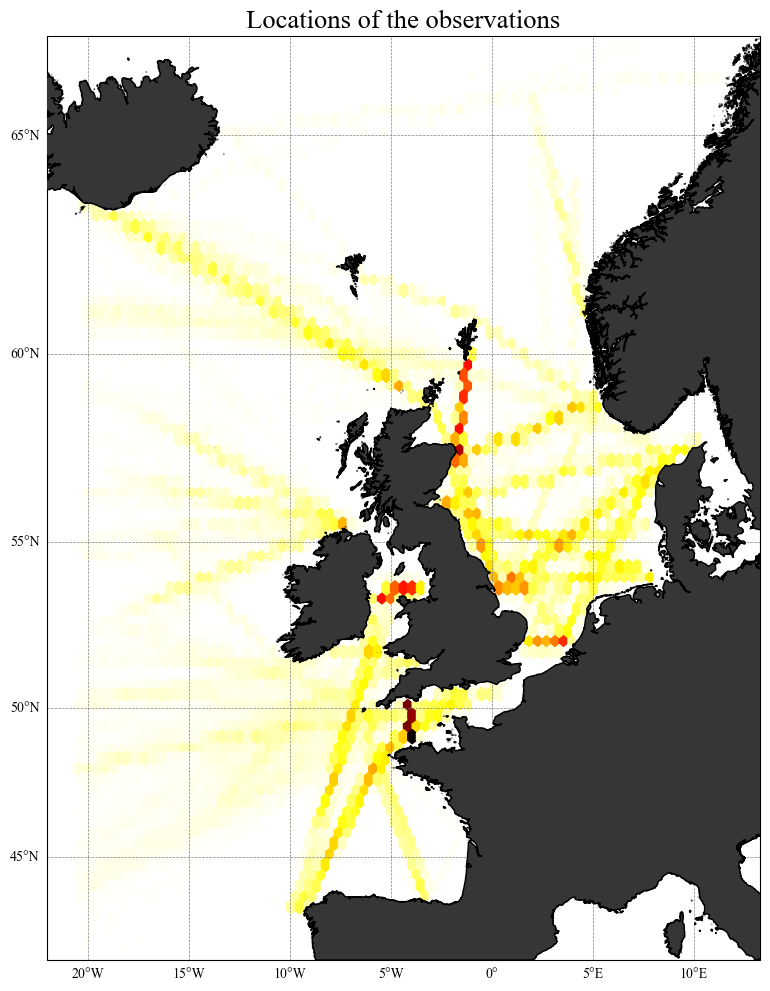

In [17]:
if makeplot

    fig = plt.figure(figsize=(12, 12))
    ax = plt.subplot(111, projection=mainproj)
    ax.hexbin(lon, lat, transform=datacrs, cmap=plt.cm.hot_r, gridsize=75)
    ax.add_feature(coast, facecolor="#363636", edgecolor="k", zorder=5)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                          linewidth=.5, color="gray", alpha=1, linestyle="--")
    gl.top_labels = false
    gl.right_labels = false
    gl.xformatter = lon_formatter
    gl.yformatter = lat_formatter
    gl.xlabel_style = Dict("size" => 10)
    gl.ylabel_style = Dict("size" => 10)
    ax.set_title("Locations of the observations")
    plt.savefig(joinpath(figdir, "location_hexbin"), dpi=300, bbox_inches="tight")
    plt.show()
    # plt.close()
end

### Finmarchicus

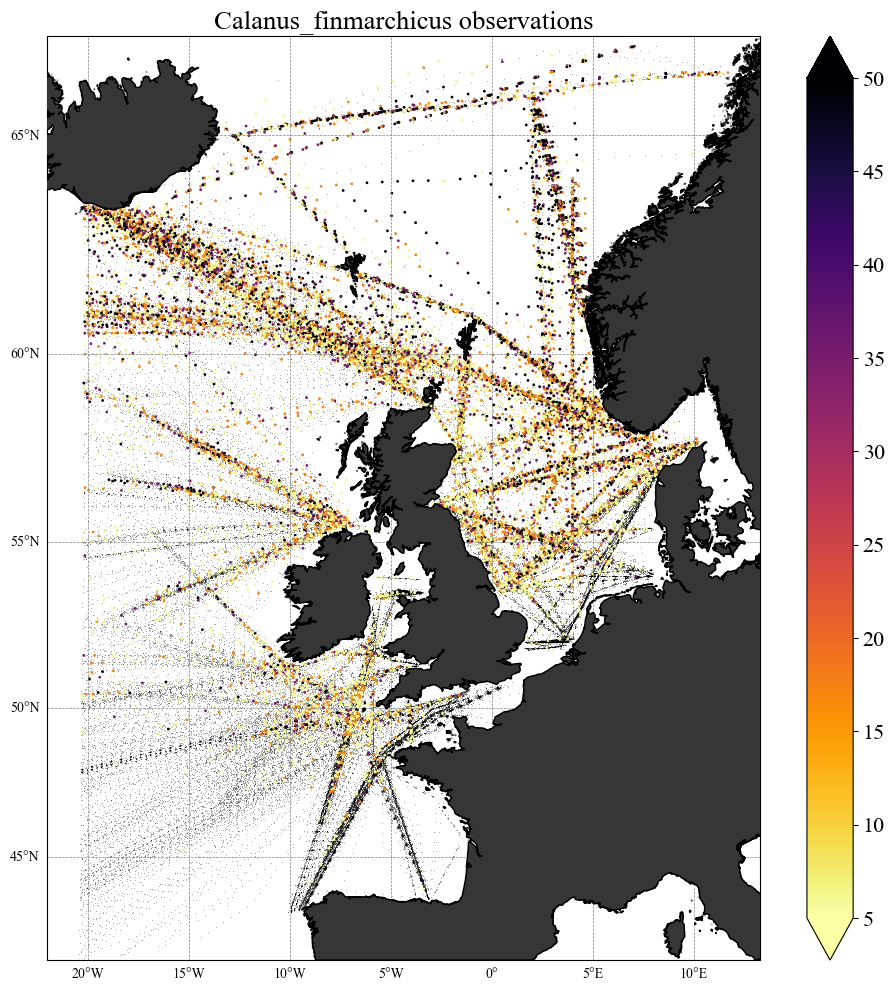

In [18]:
if makeplot
    countmin = 5
    fig = plt.figure(figsize=(12, 12))
    ax = plt.subplot(111, projection=mainproj)
    ax.scatter(lon, lat, s=.1, lw=.1, color="k", transform=datacrs)
    indexplot = findall(calanus_finmarchicus .>= countmin)
    scat = ax.scatter(lon[indexplot], lat[indexplot], s=1, c=calanus_finmarchicus[indexplot], 
                      cmap=plt.cm.inferno_r, vmin=countmin, vmax=50., transform=datacrs)

    cb = plt.colorbar(scat, extend="both")

    ax.add_feature(coast, facecolor="#363636", edgecolor="k", zorder=5)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                          linewidth=.5, color="gray", alpha=1, linestyle="--")
    gl.top_labels = false
    gl.right_labels = false
    gl.xformatter = lon_formatter
    gl.yformatter = lat_formatter
    gl.xlabel_style = Dict("size" => 10)
    gl.ylabel_style = Dict("size" => 10)
    ax.set_title("Calanus_finmarchicus observations")

    plt.savefig(joinpath(figdir, "count_calanus_finmarchicus2.jpg"), dpi=300, bbox_inches="tight")

    plt.show()
end

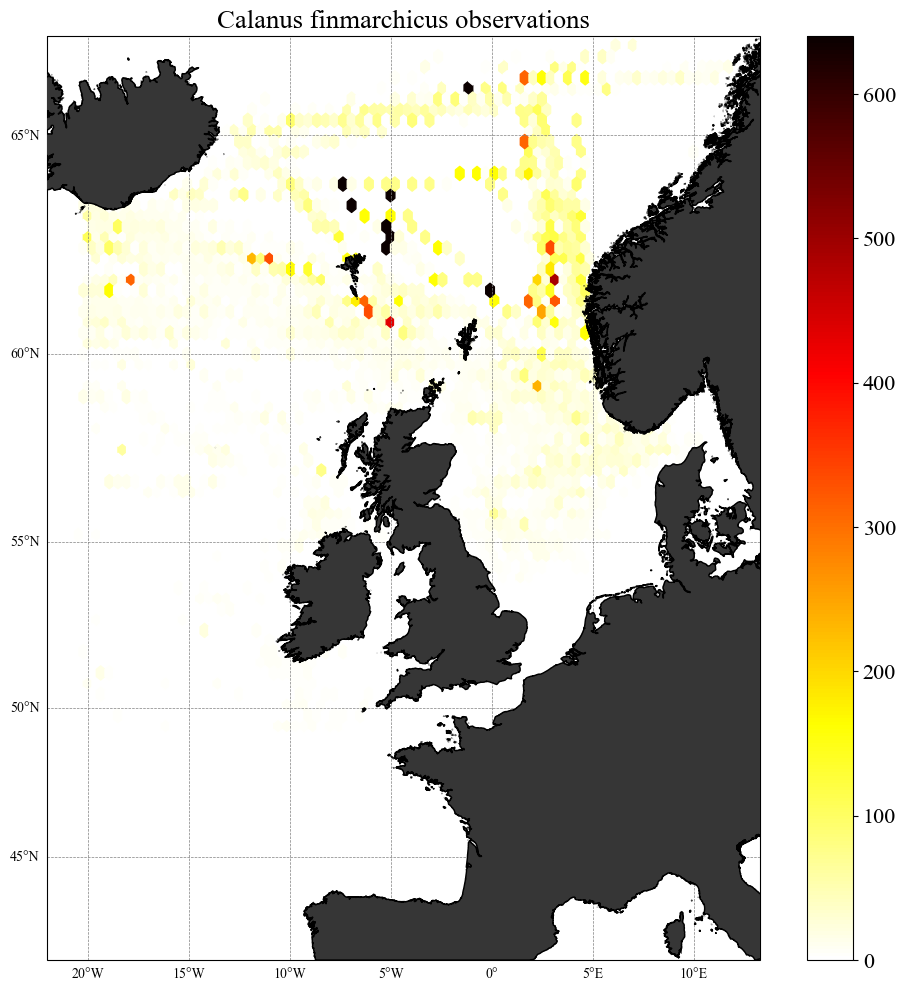

In [19]:
if makeplot
    fig = plt.figure(figsize=(12, 12))
    ax = plt.subplot(111, projection=mainproj)
    hb = ax.hexbin(lon, lat, C=calanus_finmarchicus, transform=datacrs, cmap=plt.cm.hot_r, gridsize=75)
    cb = plt.colorbar(hb)
    ax.add_feature(coast, facecolor="#363636", edgecolor="k", zorder=5)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                          linewidth=.5, color="gray", alpha=1, linestyle="--")
    gl.top_labels = false
    gl.right_labels = false
    gl.xformatter = lon_formatter
    gl.yformatter = lat_formatter
    gl.xlabel_style = Dict("size" => 10)
    gl.ylabel_style = Dict("size" => 10)
    ax.set_title("Calanus finmarchicus observations")

    plt.savefig(joinpath(figdir, "count_calanus_finmarchicus_hexbin.jpg"), dpi=300, bbox_inches="tight")

    plt.show()
end

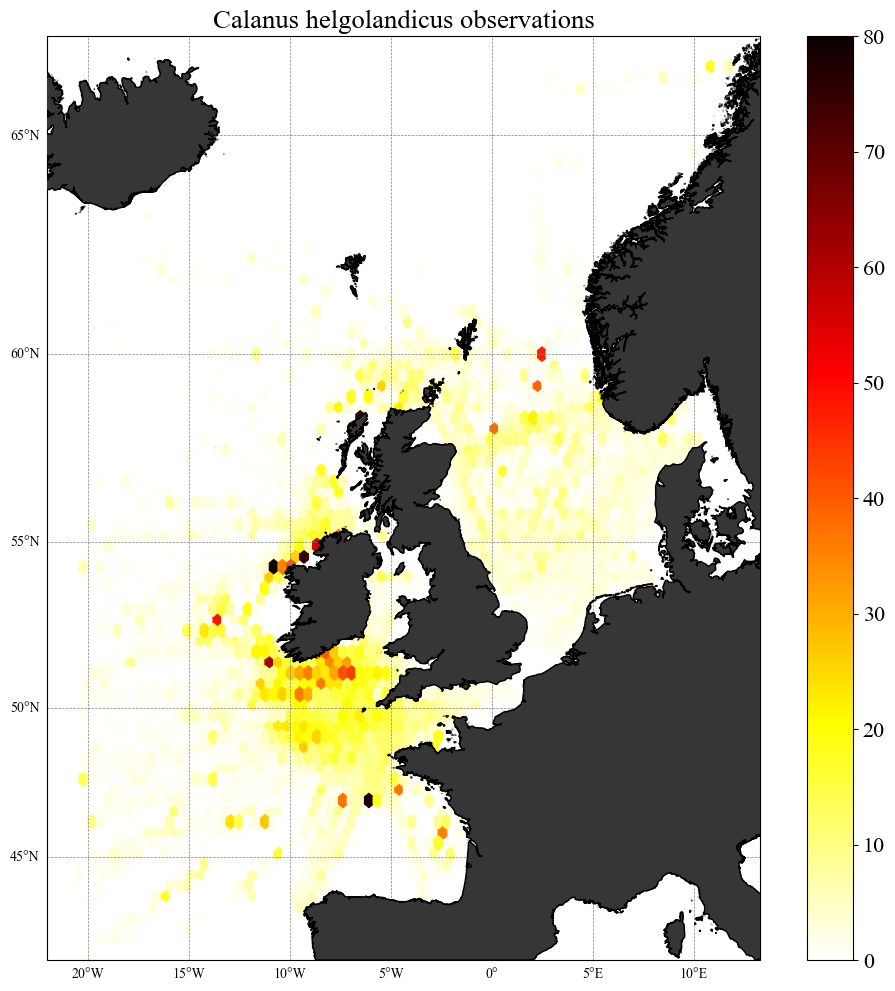

In [20]:
if makeplot
    fig = plt.figure(figsize=(12, 12))
    ax = plt.subplot(111, projection=mainproj)
    hb = ax.hexbin(lon, lat, C=calanus_helgolandicus, transform=datacrs, cmap=plt.cm.hot_r, gridsize=75)
    cb = plt.colorbar(hb)
    ax.add_feature(coast, facecolor="#363636", edgecolor="k", zorder=5)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                          linewidth=.5, color="gray", alpha=1, linestyle="--")
    gl.top_labels = false
    gl.right_labels = false
    gl.xformatter = lon_formatter
    gl.yformatter = lat_formatter
    gl.xlabel_style = Dict("size" => 10)
    gl.ylabel_style = Dict("size" => 10)
    ax.set_title("Calanus helgolandicus observations")

    plt.savefig(joinpath(figdir, "count_calanus_helgolandicus_hexbin.jpg"), dpi=300, bbox_inches="tight")

    plt.show()
end

#### Location of zeros

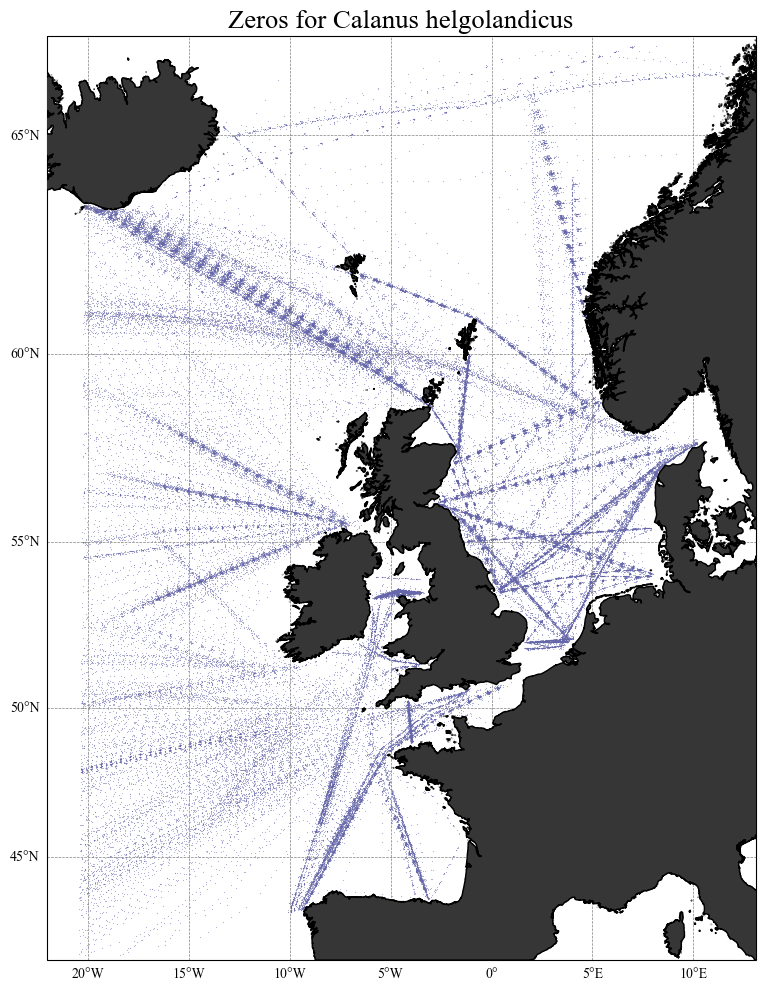

In [21]:
zerosloc1 = findall(calanus_finmarchicus .== 0.)
lonz1 = lon[zerosloc1]
latz1 = lat[zerosloc1]
zerosloc2 = findall(calanus_helgolandicus .== 0.)
lonz2 = lon[zerosloc2]
latz2 = lat[zerosloc2]

if makeplot

    fig = plt.figure(figsize=(12, 12))
    ax = plt.subplot(111, projection=mainproj)
    #ax.scatter(0, 0, s=2, lw=.1, alpha=.95, color=mycolor, transform=datacrs, label="0's for Calanus finmarchicus")
    #ax.scatter(0, 0, s=2, lw=.1, alpha=.95, color="#FF9935", transform=datacrs, label="0's for Calanus helgolandicus")
    ax.scatter(lonz1, latz1, s=.5, lw=.1, alpha=.5, color=mycolor, transform=datacrs)
    #ax.scatter(lonz2, latz2, s=.5, lw=.1, alpha=.5, color="#FF9935", transform=datacrs)
    #ax.legend()

    ax.add_feature(coast, facecolor="#363636", edgecolor="k", zorder=5)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                          linewidth=.5, color="gray", alpha=1, linestyle="--")
    gl.top_labels = false
    gl.right_labels = false
    gl.xformatter = lon_formatter
    gl.yformatter = lat_formatter
    gl.xlabel_style = Dict("size" => 10)
    gl.ylabel_style = Dict("size" => 10)
    ax.set_title("Zeros for Calanus finmarchicus")

    plt.savefig(joinpath(figdir, "zeros_calanus_finmarchicus3.jpg"), dpi=300, bbox_inches="tight")

    plt.close()

    fig = plt.figure(figsize=(12, 12))
    ax = plt.subplot(111, projection=mainproj)
    ax.scatter(lonz2, latz2, s=.5, lw=.1, alpha=.5, color=mycolor, transform=datacrs)

    ax.add_feature(coast, facecolor="#363636", edgecolor="k", zorder=5)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                          linewidth=.5, color="gray", alpha=1, linestyle="--")
    gl.top_labels = false
    gl.right_labels = false
    gl.xformatter = lon_formatter
    gl.yformatter = lat_formatter
    gl.xlabel_style = Dict("size" => 10)
    gl.ylabel_style = Dict("size" => 10)
    ax.set_title("Zeros for Calanus helgolandicus")

    plt.savefig(joinpath(figdir, "zeros_calanus_helgolandicus3.jpg"), dpi=300, bbox_inches="tight")

    plt.show()
end

#### Calanus helgolandicus

In [22]:
if makeplot

    countmin = 5
    fig = plt.figure(figsize=(12, 12))
    ax = plt.subplot(111, projection=mainproj)

    ax.scatter(lon[calanus_helgolandicus .> 0], lat[calanus_helgolandicus .> 0], 
        s=.1, lw=.1, color="k", transform=datacrs)
    indexplot = findall(calanus_helgolandicus .>= countmin)
    scat = ax.scatter(lon[indexplot], lat[indexplot], s=1, c=calanus_helgolandicus[indexplot], 
                      cmap=plt.cm.inferno_r, vmin=countmin, vmax=50., transform=datacrs)

    cb = plt.colorbar(scat, extend="both")

    ax.add_feature(coast, facecolor="#363636", edgecolor="k", zorder=5)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                          linewidth=.5, color="gray", alpha=1, linestyle="--")
    gl.top_labels = false
    gl.right_labels = false
    gl.xformatter = lon_formatter
    gl.yformatter = lat_formatter
    gl.xlabel_style = Dict("size" => 10)
    gl.ylabel_style = Dict("size" => 10)
    ax.set_title("Calanus helgolandicus observations")

    plt.savefig(joinpath(figdir, "count_calanus_helgolandicus2.jpg"), dpi=300, bbox_inches="tight")

    plt.close()
end